# 0. DeeplearningをPytorchにより実装して、MINISTを分類

## パッケージのimportとPyTorchのバージョンを確認

In [1]:
# パッケージのimport
import math
import matplotlib.pyplot as plt
import numpy as np

import shap

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision

from torch.autograd import Variable  # 自動微分用

print(torch.__version__)

1.7.0


In [25]:
# PyTorchのバージョン確認
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

if torch.cuda.is_available():
    print(f"GPU Driver is {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

PyTorch Version:  1.7.0
Torchvision Version:  0.8.1
GPU Driver is GeForce RTX 2070


In [3]:
def calc_output_shape(C_in, H_in, W_in, kernel_size):
    """
    **

    Parameters
    ----------
    C_in : int
        Color channel 
    H_in : int
        Hight channel 
    W_in : int
        Width channel 
    """

    padding = [0, 0]
    dilation = [1, 1]
    stride = [1,1]

    H_out = math.floor((H_in + 2 * padding[0] - dilation[0] * (kernel_size - 1) - 1) / stride[0] + 1 )
    W_out = math.floor((W_in + 2 * padding[1] - dilation[1] * (kernel_size - 1) - 1) / stride[1] + 1 )
    print(f"H_out is {H_out}, W_out is {W_out}")
    
calc_output_shape(1,28,28,3)

H_out is 26, W_out is 26


## MINISTデータセットのダウンロード

In [33]:
BATCH_SIZE = 100

## MINISTデータセットのダウンロード

# train set のダウンロード
print(f"□□□ train_set □□□\n")
train_set = torchvision.datasets.MNIST('../data', train=True, download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize(
                                               (0.1307,), (0.3081,))
                                       ]))
print(train_set)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=2)

# train 加工のダウンロード
print(f"\n□□□ test_set □□□\n")

test_set = torchvision.datasets.MNIST('../data', train=False, download=True,
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(
                                              (0.1307,), (0.3081,))
                                      ]))

print(test_set)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)


print(f"\nDateset size is {train_set[0][0].shape} (channel × hight × width?)")

□□□ train_set □□□

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

□□□ test_set □□□

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Dateset size is torch.Size([1, 28, 28]) (channel × hight × width?)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


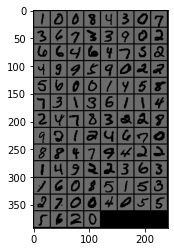

In [35]:
## サンプルの表示
def imshow(img):
    """
    MINISTデータセットのサンプルを表示する。
    """
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)) * -1)


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## ニューラルネットワークの定義

In [36]:
# ネットワークを定義する関数
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        '''
        畳み込み層の設定
        
            □□□　第1層の設定  □□□
             入力チャネル = 1
             出力チャネル = 16
             畳み込みする正方形フィルタ（カーネル）1辺のサイズ = 3
            データ形式
             入力テンソル = (c,w,h) is (1,28,28)
             出力テンソル = (c,w,h) is (16,26,26)
             
             □□□ 第2層の設定  □□□
             入力チャネル = 16
             出力チャネル = 32
             畳み込みする正方形フィルタ（カーネル）1辺のサイズ = 3
            データ形式
             入力テンソル = (c,w,h) is (16,13,13)
             出力テンソル = (c,w,h) is (32,11,11)
             
        '''
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(), 
            nn.MaxPool2d(2, stride=2),
        )
        

        '''
        全結合層の設定
        
            □□□　第1層の設定  □□□
            第1 fully connect層（全結合）
             入力数 = 800
             出力数 = 120
             
             □□□ 第2層の設定  □□□
            第2 fully connect層（全結合）
             入力数 = 120
             出力数 = 10
        '''
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 5 * 5, 120),
            nn.ReLU(),  # 活性化関数
            nn.Linear(120, 10),
        )

    def forward(self, x):
        
        x = self.conv_layers(x)
        
        x = x.view(x.size()[0], -1)  # (32,5,5) -> (800)
        
        x = self.fc_layers(x)
        
        return x

In [38]:
# ネットワークを定義する関数
device = torch.device("cuda")

net = Net()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.005)

print(f"□ about net")
print(net)
print(f"\n□ about net")
print(criterion)
print(f"\n□ about net")
print(optimizer)

□ about net
Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=800, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)

□ about net
CrossEntropyLoss()

□ about net
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.005
)


## ネットワークの学習

In [43]:
# 学習

train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #testのlossを保持するlist
test_acc_value=[]        #testのaccuracyを保持するlist 

EPOCH = 20

for epoch in range(EPOCH):
    
    print('epoch', epoch + 1)    #epoch数の出力
    
    for (inputs, labels) in train_loader:
        '''
        inputs is 100 images tensor
        '''
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad() # 勾配情報を初期化する
        outputs = net(inputs)
        '''
        学習中のモデルと正解ラベルの誤差を計測する。
        設定した「CrossEntropyLoss()」内で、出力した予測値のSoftmaxを取る
        ・outputs → [[0.1, 0.2 ... 0.2],[0.1, 0.2 ... 0.2]...[0.1, 0.2 ... 0.2]]
        ・labels → [1, 4, ... 6]
        '''
        loss = criterion(outputs, labels)
        '''
        計算したlossから勾配情報を計算
        各層のGradへ値を入力する
        '''
        loss.backward()
        optimizer.step() # loss.backward()で計算した勾配をもとにパラメータを更新
        
    sum_loss = 0.0          #lossの合計
    sum_correct = 0         #正解率の合計
    sum_total = 0           #dataの数の合計
    
    #train dataを使ってテストをする(パラメータ更新がないようになっている)
    for (inputs, labels) in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # 指標の計算
        sum_loss += loss.item()                            #lossを足していく
        _, predicted = outputs.max(1)                      #出力の最大値の添字(予想位置)を取得
        sum_total += labels.size(0)                        #labelの数を足していくことでデータの総和を取る
        sum_correct += (predicted == labels).sum().item()  #予想位置と実際の正解を比べ,正解している数だけ足す
        
    '''
    loss と accuracyを出力
    ・loss → outputsとlabelsとのlossをcriterion(outputs, labels)により計算
    ・accuracy → 正解率　予測した全体数で正解した数を割る
    '''
    print(" train mean loss={:.4f}, accuracy={:.4f}"
          .format(sum_loss*BATCH_SIZE/len(train_loader.dataset), float(sum_correct/sum_total)))
    
    # traindataのlossをグラフ描画のためにlistに保持
    train_loss_value.append(sum_loss*BATCH_SIZE/len(train_loader.dataset))
    # traindataのaccuracyをグラフ描画のためにlistに保持
    train_acc_value.append(float(sum_correct/sum_total))

    for (inputs, labels) in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        sum_loss += loss.item()                            #lossを足していく
        _, predicted = outputs.max(1)                      #出力の最大値の添字(予想位置)を取得
        sum_total += labels.size(0)                        #labelの数を足していくことでデータの総和を取る
        sum_correct += (predicted == labels).sum().item()  #予想位置と実際の正解を比べ,正解している数だけ足す
   
    print(" test  mean loss={:.4f}, accuracy={:.4f}"
          .format(sum_loss*BATCH_SIZE/len(test_loader.dataset), float(sum_correct/sum_total)))
    test_loss_value.append(sum_loss*BATCH_SIZE/len(test_loader.dataset))
    test_acc_value.append(float(sum_correct/sum_total))

epoch 1
 train mean loss=0.3722, accuracy=0.8925
 test  mean loss=2.5837, accuracy=0.8932
epoch 2
 train mean loss=0.3407, accuracy=0.9007
 test  mean loss=2.3653, accuracy=0.9013
epoch 3
 train mean loss=0.3182, accuracy=0.9060
 test  mean loss=2.2076, accuracy=0.9069
epoch 4
 train mean loss=0.2996, accuracy=0.9116
 test  mean loss=2.0778, accuracy=0.9126
epoch 5
 train mean loss=0.2836, accuracy=0.9162
 test  mean loss=1.9656, accuracy=0.9170
epoch 6
 train mean loss=0.2684, accuracy=0.9206
 test  mean loss=1.8604, accuracy=0.9215
epoch 7
 train mean loss=0.2565, accuracy=0.9238
 test  mean loss=1.7776, accuracy=0.9245
epoch 8
 train mean loss=0.2444, accuracy=0.9276
 test  mean loss=1.6935, accuracy=0.9284
epoch 9
 train mean loss=0.2348, accuracy=0.9306
 test  mean loss=1.6260, accuracy=0.9311
epoch 10
 train mean loss=0.2233, accuracy=0.9341
 test  mean loss=1.5453, accuracy=0.9348
epoch 11
 train mean loss=0.2138, accuracy=0.9375
 test  mean loss=1.4803, accuracy=0.9381
epoch 12

loss function changes over time


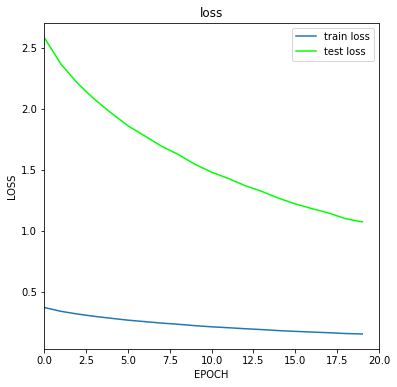


accuracy function changes over time


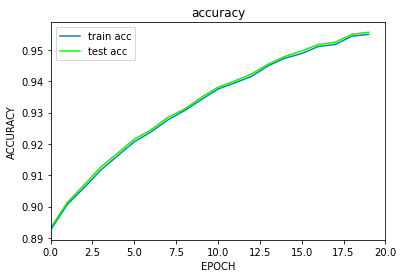

In [47]:
# 結果の描画
plt.figure(figsize=(6,6))      #グラフ描画用

#以下グラフ描画
print("loss function changes over time")
plt.plot(range(EPOCH), train_loss_value)
plt.plot(range(EPOCH), test_loss_value, c='#00ff00')
plt.xlim(0, EPOCH)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.savefig("loss_image.png")
plt.show()
plt.clf()

print("\naccuracy function changes over time")
plt.plot(range(EPOCH), train_acc_value)
plt.plot(range(EPOCH), test_acc_value, c='#00ff00')
plt.xlim(0, EPOCH)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.savefig("accuracy_image.png")
plt.show()

## Shapによる分析

In [66]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, labels = batch
images = images.to(device)

background,test_images = images[:90], images[90:100]

e = shap.DeepExplainer(net, background)

print(f"background is {background.shape}")
print(f"test_images is {test_images.shape}")

shap_values = e.shap_values(test_images)

background is torch.Size([90, 1, 28, 28])
test_images is torch.Size([10, 1, 28, 28])


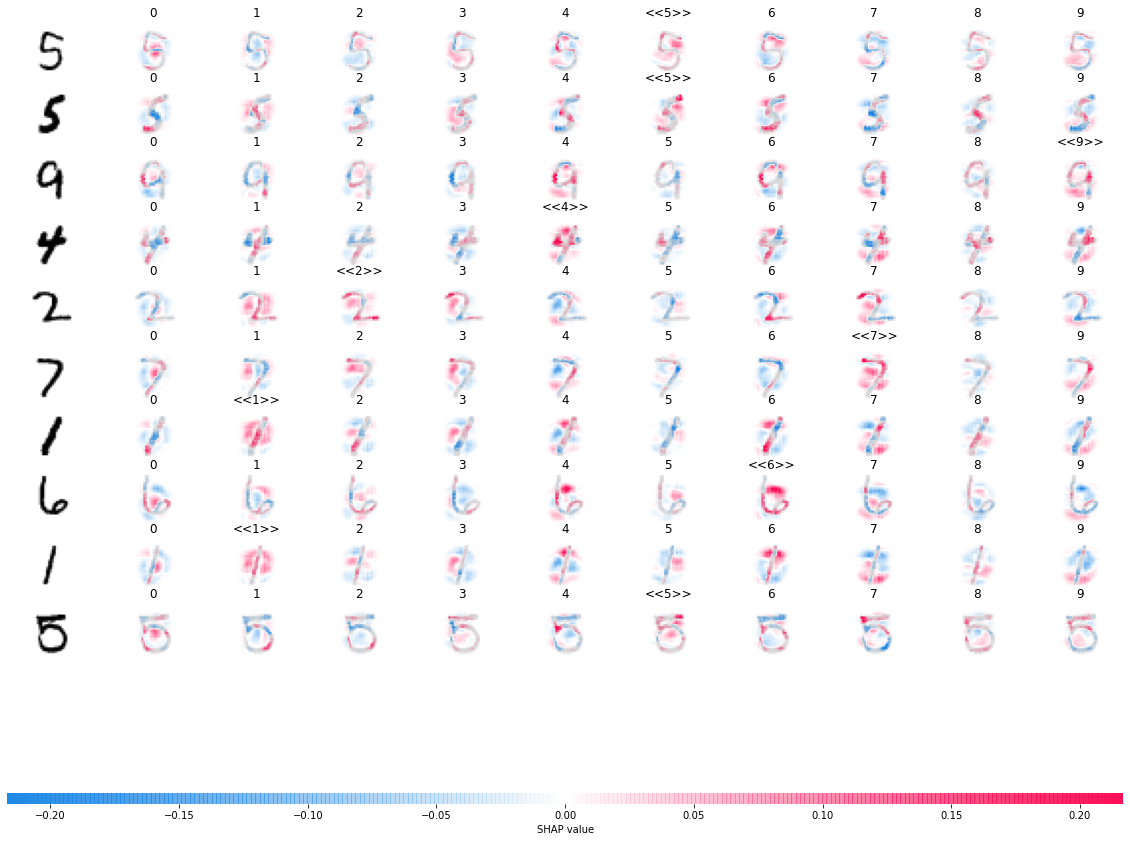

In [67]:
# 正解ラベルの予測
outputs = net(test_images).max(1)
predict = outputs[1].to('cpu').detach().numpy().copy()

# shap値の計算
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
predict_numpy = np.array([[f"<<{i}>>" if predict[j] == i else i for i in range(0,10)] for j in range(0,10)])

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy ,predict_numpy)